<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [10]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 512
batch_size = 128

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [47]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

#x = layers.Dense(4*latent_dim)(x)
#x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [49]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*4*512)(x)
x = layers.ReLU()(x)

x = layers.Reshape((4,4,512))(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 3, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding ='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding = 'same')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding='same')(x)

#x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(64, 1, 3, initializer, 'min', padding = 'same')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 3, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_56 (ReLU)             (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              2099200   
                                                                 
 re_lu_57 (ReLU)             (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 8192)              16785408  
                                                                 
 re_lu_58 (ReLU)             (None, 8192)              0   

In [50]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               20662848  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         36483587  
                                                                 
Total params: 57146435 (218.00 MB)
Trainable params: 57123267 (217.91 MB)
Non-trainable params: 23168 (90.50 KB)
_________________________________________________________________


In [51]:
K.clear_session()

In [52]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1173, decay_rate=0.93)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 94s 162ms/step - loss: 0.0343 - accuracy: 0.4816 - val_loss: 0.0283 - val_accuracy: 0.4747
Epoch 2/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0211 - accuracy: 0.5487 - val_loss: 0.0239 - val_accuracy: 0.5454
Epoch 3/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0176 - accuracy: 0.5968 - val_loss: 0.0203 - val_accuracy: 0.5725
Epoch 4/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0160 - accuracy: 0.6103 - val_loss: 0.0169 - val_accuracy: 0.5985
Epoch 5/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0149 - accuracy: 0.6177 - val_loss: 0.0159 - val_accuracy: 0.6110
Epoch 6/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0142 - accuracy: 0.6240 - val_loss: 0.0144 - val_accuracy: 0.6193
Epoch 7/30
391/391 [==============================] - 61s 156ms/step - loss: 0.0135 - accuracy: 0.6305 - val_loss: 0.0143 - val_ac

In [53]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00005, decay_steps=1173, decay_rate=0.93)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse',metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])

Epoch 1/20
391/391 [==============================] - 92s 160ms/step - loss: 0.0079 - accuracy: 0.7251 - val_loss: 0.0087 - val_accuracy: 0.7148
Epoch 2/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0078 - accuracy: 0.7255 - val_loss: 0.0087 - val_accuracy: 0.7260
Epoch 3/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0077 - accuracy: 0.7263 - val_loss: 0.0089 - val_accuracy: 0.7130
Epoch 4/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0076 - accuracy: 0.7270 - val_loss: 0.0089 - val_accuracy: 0.7251
Epoch 5/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0075 - accuracy: 0.7280 - val_loss: 0.0087 - val_accuracy: 0.7236
Epoch 6/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0074 - accuracy: 0.7290 - val_loss: 0.0087 - val_accuracy: 0.7181
Epoch 7/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0073 - accuracy: 0.7301 - val_loss: 0.0086 - val_ac

In [55]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.000005, decay_steps=782, decay_rate=0.9)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse',metrics='accuracy')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])

Epoch 1/20
391/391 [==============================] - 94s 161ms/step - loss: 0.0061 - accuracy: 0.7421 - val_loss: 0.0083 - val_accuracy: 0.7348
Epoch 2/20
391/391 [==============================] - 62s 160ms/step - loss: 0.0061 - accuracy: 0.7430 - val_loss: 0.0083 - val_accuracy: 0.7337
Epoch 3/20
391/391 [==============================] - 62s 160ms/step - loss: 0.0061 - accuracy: 0.7429 - val_loss: 0.0083 - val_accuracy: 0.7319
Epoch 4/20
391/391 [==============================] - 62s 160ms/step - loss: 0.0060 - accuracy: 0.7426 - val_loss: 0.0083 - val_accuracy: 0.7321
Epoch 5/20
391/391 [==============================] - 62s 160ms/step - loss: 0.0060 - accuracy: 0.7429 - val_loss: 0.0083 - val_accuracy: 0.7325
Epoch 6/20
391/391 [==============================] - 62s 160ms/step - loss: 0.0060 - accuracy: 0.7432 - val_loss: 0.0083 - val_accuracy: 0.7305
Epoch 7/20
391/391 [==============================] - 62s 159ms/step - loss: 0.0060 - accuracy: 0.7432 - val_loss: 0.0083 - val_ac

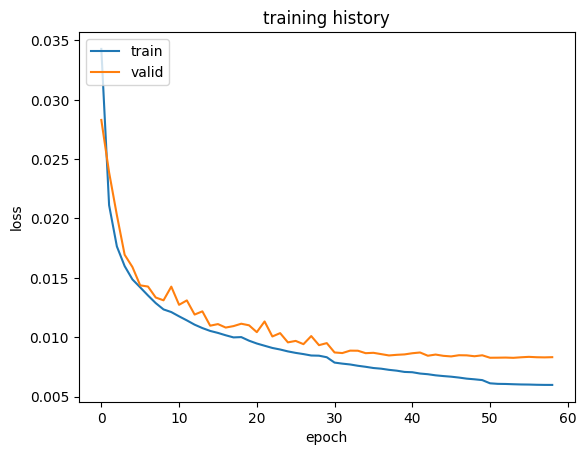

In [56]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

In [57]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

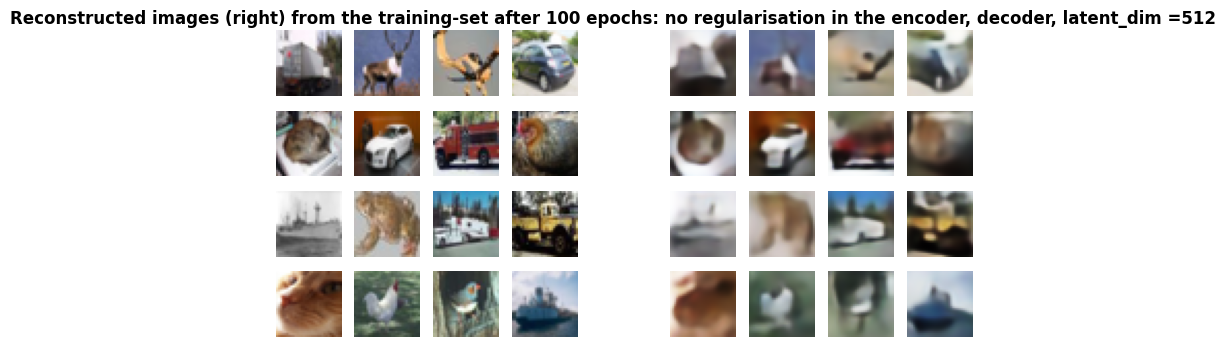

In [58]:
plot_reconstruction(img_train, 'training', 123, 100)

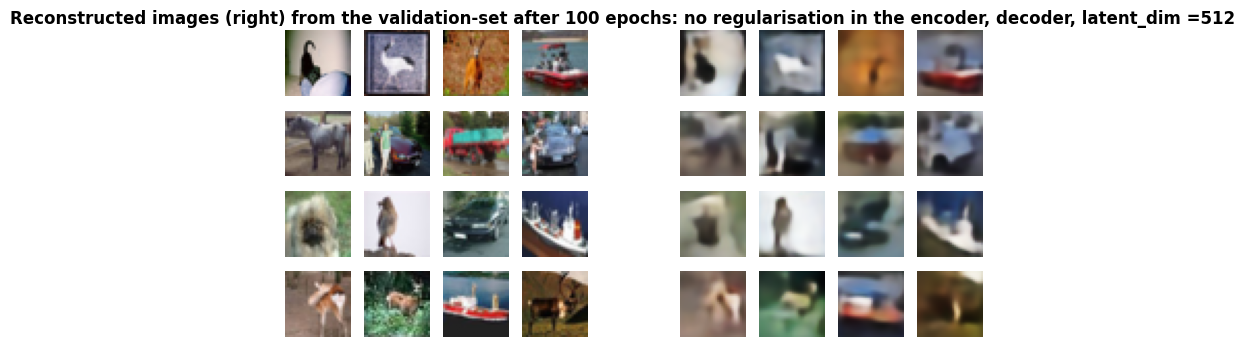

In [59]:
plot_reconstruction(img_valid, 'validation', 123, 100)